# WISONet δD Retrievals
This notebook demonstrates how averaging kernels and a priori values affect satellite δD retrievals.


In [117]:
!curl -L "https://rice.box.com/shared/static/bcoy3ob0dme3umpurqmf0p6o48bznkj1" -o SWING3_2006_subset.nc
!curl -L "https://rice.box.com/shared/static/uuy9m15qc1p7s4wm1yrzfzxc6knx7hzw" -o TES_monthly_5deg_strict.nc


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100     8    0     8    0     0      7      0 --:--:--  0:00:01 --:--:--  8000
100 12.7M  100 12.7M    0     0  6217k      0  0:00:02  0:00:02 --:--:-- 51.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100    10    0    10    0     0      9      0 --:--:--  0:00:01 --:--:-- 10000
100 3095M  100 3095M    0     0  40.6M      0  0:01:16  0:01:16 --:--:-- 41.2M


In [131]:
!ls -lh


total 3.1G
drwxr-xr-x 1 root root 4.0K Jun 11 13:37 sample_data
-rw-r--r-- 1 root root  13M Jun 12 21:33 SWING3_2006_subset.nc
-rw-r--r-- 1 root root 3.1G Jun 12 21:35 TES_monthly_5deg_strict.nc


In [152]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import ipywidgets as widgets
from ipywidgets import interact, fixed
# import warnings

@interact(month=widgets.IntSlider(min=1, max=12, step=1, value=1, description='Month'))
def update_plot(month):
    m = month - 1

    # === Construct last day of month string ===
    last_day = calendar.monthrange(2006,month)[1]
    user_date_str = f'2006-{month:02d}-{last_day}'
    target_date = datetime.strptime(user_date_str, '%Y-%m-%d')

    # === Load SWING3 ===
    ds = xr.open_dataset("SWING3_2006_subset.nc")
    lon = ds['lon'].values
    lat = ds['lat'].values
    p = ds['p'].values
    month = ds['month'].values
    dD = ds['dD'].values.astype(float)
    q = ds['q'].values.astype(float)

    # === Mask out fill values ===
    dD[dD == -999] = np.nan
    q[q == -999] = np.nan

    # === Subset latitude range [-10, 10] ===
    lat_mask = (lat >= 20) & (lat <= 40)
    dD_eq = dD[m, :, lat_mask, :]  # [month, level, lat, lon]
    q_eq  = q[m, :, lat_mask, :]

    # === Average over lon and lat ===
    dD_mean = np.nanmean(np.nanmean(dD_eq, axis=2), axis=0)
    q_mean = np.nanmean(np.nanmean(q_eq, axis=2), axis=0)

    # === Constants ===
    Rvsmow = 3.1152e-4
    M_air = 28.9647
    M_H2O = 18.01528

    # === Convert q from mass to VMR ===
    q_vmr = (q_mean / M_H2O) / ((q_mean / M_H2O) + ((1 - q_mean) / M_air))
    HDO_vmr1 = q_vmr * Rvsmow * (1 + dD_mean / 1000)

    # === Load TES ===
    sat = xr.open_dataset("TES_monthly_5deg_strict.nc")
    tes_lat = sat['lat'].values
    tes_lon = sat['lon'].values
    tes_p = sat['level'].values
    tes_time = sat['time'].values

    # === Time matching ===
    base_date = datetime(2000, 1, 1)
    if np.issubdtype(tes_time.dtype, np.datetime64):
        t_tes = np.argmin(np.abs(tes_time - np.datetime64(user_date_str)))
    else:
        target_days = (target_date - base_date).days
        t_tes = np.argmin(np.abs(tes_time - target_days))

    # === Spatial subset: Equatorial Pacific [-10,10] ===
    ilat_tes = np.where((tes_lat >= 20) & (tes_lat <= 40))[0]
    ilon_tes = np.arange(len(tes_lon))

    HDO_ret = sat['HDO_vmr'].values
    HDO_a   = sat['HDO_ConstraintVector'].values
    AK      = sat['AK_HDO'].values

    lat_mask = (tes_lat >= -10) & (tes_lat <= 10)
    HDO_ret = HDO_ret[t_tes, :, lat_mask, :]
    HDO_a   = HDO_a[t_tes, :, lat_mask, :]
    AK      = AK[t_tes, :, :, lat_mask, :]

    # === Mask invalid values ===
    HDO_ret[HDO_ret == -999] = np.nan
    HDO_a[HDO_a == -999] = np.nan
    AK[AK == -999] = np.nan

    # === Average over lat and lon ===
    HDO_ret_avg = np.nanmean(np.nanmean(HDO_ret, axis=2), axis=0)
    HDO_a_avg   = np.nanmean(np.nanmean(HDO_a, axis=2), axis=0)
    AK_avg      = np.nanmean(np.nanmean(AK, axis=3), axis=0)

    # === Interpolate model to TES pressure ===
    HDO_vmr1_interp = np.interp(tes_p, p[::-1], HDO_vmr1[::-1])

    # === Apply AK ===
    ln_true = np.log(HDO_vmr1_interp)
    ln_apriori = np.log(HDO_a_avg)
    ln_smoothed = ln_apriori + AK_avg.T @ (ln_true - ln_apriori)
    HDO_recon = np.exp(ln_smoothed)

    # === Plot ===
    plt.figure()
    plt.semilogx(HDO_ret_avg, tes_p, 'b-o', label='TES Retrieved')
    plt.semilogx(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
    plt.semilogx(HDO_vmr1_interp, tes_p, 'k-', label='Model True')
    plt.semilogx(HDO_recon, tes_p, 'm-.', label='AK-applied')

    plt.gca().invert_yaxis()
    plt.xlabel('HDO VMR [mol/mol]')
    plt.ylabel('Pressure [hPa]')
    plt.title(f'TES vs. Model (10S-10N, {user_date_str})')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.ylim(850, 250)  # Inverted y-axis: top = 250, bottom = 850
    plt.xlim(1e-7, 1e-5)  # Inverted y-axis: top = 250, bottom = 850
    plt.show()


interactive(children=(IntSlider(value=1, description='Month', max=12, min=1), Output()), _dom_classes=('widget…

TES matched date index: 22
TES matched time value: 2006-08-31T00:00:00.000000000


In [184]:
from IPython.display import display, Javascript

display(Javascript("""
Jupyter.notebook.metadata.widgets = {};
alert('Widget metadata cleared. Save the notebook now to apply the fix.');
"""))


<IPython.core.display.Javascript object>

In [183]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import ipywidgets as widgets
from ipywidgets import interact, interactive_output, VBox, HBox
import matplotlib.colors as mcolors

# === Load Datasets Once ===
ds = xr.open_dataset("SWING3_2006_subset.nc")
sat = xr.open_dataset("TES_monthly_5deg_strict.nc")

# === Common Dimensions ===
lon = ds['lon'].values
lat = ds['lat'].values
# Convert lon from 0–360 to -180–180 if needed
def to_minus180_180(lon_array):
    return ((lon_array + 180) % 360) - 180

lon = to_minus180_180(lon)
p = ds['p'].values

tes_lat = sat['lat'].values
tes_lon = sat['lon'].values
tes_p = sat['level'].values
tes_time = sat['time'].values

# === Widget Controls ===
month_slider = widgets.IntSlider(min=1, max=12, step=1, value=1, description='Month')
lat_slider = widgets.FloatSlider(min=-30, max=30, step=5, value=30, description='Lat Center')
log_toggle = widgets.Checkbox(value=True, description='Log X-axis')
step_dropdown = widgets.Dropdown(
    options=['All', 'A priori only', 'Model vs A priori', 'AK-applied only', 'TES vs AK'],
    value='All',
    description='Step View:'
)
ak_toggle = widgets.Checkbox(value=False, description='Show AK Matrix')

# === Plot Function ===
def update_plot(month, lat_center, log_x, step_view, show_ak):
    m = month - 1
    lat_band = 10

    last_day = calendar.monthrange(2006, month)[1]
    user_date_str = f'2006-{month:02d}-{last_day}'
    target_date = datetime.strptime(user_date_str, '%Y-%m-%d')

    dD = ds['dD'].values.astype(float)
    q = ds['q'].values.astype(float)
    dD[dD == -999] = np.nan
    q[q == -999] = np.nan
    lat_mask = (lat >= lat_center - lat_band/2) & (lat <= lat_center + lat_band/2)
    lon_mask = (lon > 0) & (lon < 20)

    dD_eq = dD[m, :, lat_mask, :][:, :, lon_mask]
    q_eq  = q[m, :, lat_mask, :][:, :, lon_mask]

    dD_mean = np.nanmean(np.nanmean(dD_eq, axis=2), axis=0)
    q_mean = np.nanmean(np.nanmean(q_eq, axis=2), axis=0)

    Rvsmow = 3.1152e-4
    M_air = 28.9647
    M_H2O = 18.01528
    q_vmr = (q_mean / M_H2O) / ((q_mean / M_H2O) + ((1 - q_mean) / M_air))
    HDO_vmr1 = q_vmr * Rvsmow * (1 + dD_mean / 1000)

    if np.issubdtype(tes_time.dtype, np.datetime64):
        t_tes = np.argmin(np.abs(tes_time - np.datetime64(user_date_str)))
    else:
        base_date = datetime(2000, 1, 1)
        target_days = (target_date - base_date).days
        t_tes = np.argmin(np.abs(tes_time - target_days))

    tes_lat_mask = (tes_lat >= lat_center - lat_band/2) & (tes_lat <= lat_center + lat_band/2)
    tes_lon_mask = (tes_lon > 0) & (tes_lon < 20)
    HDO_ret = sat['HDO_vmr'].values[t_tes, :, tes_lat_mask, :]
    HDO_a   = sat['HDO_ConstraintVector'].values[t_tes, :, tes_lat_mask, :]
    AK      = sat['AK_HDO'].values[t_tes, :, :, tes_lat_mask, :]


    HDO_ret[HDO_ret == -999] = np.nan
    HDO_a[HDO_a == -999] = np.nan
    AK[AK == -999] = np.nan

    HDO_ret_avg = np.nanmean(np.nanmean(HDO_ret, axis=2), axis=0)
    HDO_a_avg   = np.nanmean(np.nanmean(HDO_a, axis=2), axis=0)
    AK_avg      = np.nanmean(np.nanmean(AK, axis=3), axis=0)

    HDO_vmr1_interp = np.interp(tes_p, p[::-1], HDO_vmr1[::-1])
    ln_true = np.log(HDO_vmr1_interp)
    ln_apriori = np.log(HDO_a_avg)
    ln_smoothed = ln_apriori + AK_avg.T @ (ln_true - ln_apriori)
    HDO_recon = np.exp(ln_smoothed)

    fig, axs = plt.subplots(1, 2 if show_ak else 1, figsize=(10 if show_ak else 6, 6))

    ax1 = axs if not show_ak else axs[0]
    if step_view == 'A priori only':
        ax1.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
    elif step_view == 'Model vs A priori':
        ax1.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
        ax1.plot(HDO_vmr1_interp, tes_p, 'k-', label='Model True')
    elif step_view == 'AK-applied only':
        ax1.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')
    elif step_view == 'TES vs AK':
        ax1.plot(HDO_ret_avg, tes_p, 'b-o', label='TES Retrieved')
        ax1.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')
    else:
        ax1.plot(HDO_ret_avg, tes_p, 'b-o', label='TES Retrieved')
        ax1.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
        ax1.plot(HDO_vmr1_interp, tes_p, 'k-', label='Model True')
        ax1.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')

    ax1.invert_yaxis()
    ax1.set_xlabel('HDO VMR [mol/mol]')
    ax1.set_ylabel('Pressure [hPa]')
    ax1.set_title(f'TES vs. Model ({lat_center-5:.0f} to {lat_center+5:.0f}°N, {user_date_str})')
    ax1.set_ylim(850, 250)
    if log_x:
        ax1.set_xscale('log')
        ax1.set_xlim(1e-7, 1e-5)
    else:
        ax1.set_xlim(0, 4e-6)
    ax1.grid(True)
    ax1.legend(loc='lower left')

    if show_ak:
        ax2 = axs[1]
        pcm = ax2.pcolormesh(tes_p, tes_p, AK_avg.T, shading='nearest', cmap='viridis', norm=mcolors.Normalize(0, 1))
        ax2.invert_yaxis()
        ax2.set_xlabel('True Level [hPa]')
        ax2.set_ylabel('Retrieved Level [hPa]')
        ax2.set_title('TES Averaging Kernel Matrix')
        plt.colorbar(pcm, ax=ax2, label='AK Value')
        ax2.grid(True)

    plt.tight_layout()
    plt.show()

# === Combine Widgets ===
ui = VBox([HBox([month_slider, lat_slider]), HBox([log_toggle, step_dropdown, ak_toggle])])
out = interactive_output(update_plot, {
    'month': month_slider,
    'lat_center': lat_slider,
    'log_x': log_toggle,
    'step_view': step_dropdown,
    'show_ak': ak_toggle
})

display(ui, out)

HDO_ret.shape

Output()

(4, 17, 72)

In [166]:
tes_lon

array([-177.5, -172.5, -167.5, -162.5, -157.5, -152.5, -147.5, -142.5,
       -137.5, -132.5, -127.5, -122.5, -117.5, -112.5, -107.5, -102.5,
        -97.5,  -92.5,  -87.5,  -82.5,  -77.5,  -72.5,  -67.5,  -62.5,
        -57.5,  -52.5,  -47.5,  -42.5,  -37.5,  -32.5,  -27.5,  -22.5,
        -17.5,  -12.5,   -7.5,   -2.5,    2.5,    7.5,   12.5,   17.5,
         22.5,   27.5,   32.5,   37.5,   42.5,   47.5,   52.5,   57.5,
         62.5,   67.5,   72.5,   77.5,   82.5,   87.5,   92.5,   97.5,
        102.5,  107.5,  112.5,  117.5,  122.5,  127.5,  132.5,  137.5,
        142.5,  147.5,  152.5,  157.5,  162.5,  167.5,  172.5,  177.5])

In [175]:
lon

array([   0.    ,    2.8125,    5.625 ,    8.4375,   11.25  ,   14.0625,
         16.875 ,   19.6875,   22.5   ,   25.3125,   28.125 ,   30.9375,
         33.75  ,   36.5625,   39.375 ,   42.1875,   45.    ,   47.8125,
         50.625 ,   53.4375,   56.25  ,   59.0625,   61.875 ,   64.6875,
         67.5   ,   70.3125,   73.125 ,   75.9375,   78.75  ,   81.5625,
         84.375 ,   87.1875,   90.    ,   92.8125,   95.625 ,   98.4375,
        101.25  ,  104.0625,  106.875 ,  109.6875,  112.5   ,  115.3125,
        118.125 ,  120.9375,  123.75  ,  126.5625,  129.375 ,  132.1875,
        135.    ,  137.8125,  140.625 ,  143.4375,  146.25  ,  149.0625,
        151.875 ,  154.6875,  157.5   ,  160.3125,  163.125 ,  165.9375,
        168.75  ,  171.5625,  174.375 ,  177.1875, -180.    , -177.1875,
       -174.375 , -171.5625, -168.75  , -165.9375, -163.125 , -160.3125,
       -157.5   , -154.6875, -151.875 , -149.0625, -146.25  , -143.4375,
       -140.625 , -137.8125, -135.    , -132.1875, 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 98.7 MB/s eta 0:00:00


In [164]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import ipywidgets as widgets
from ipywidgets import interact, interactive_output, VBox, HBox
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.widgets import RectangleSelector

# === Load Datasets Once ===
ds = xr.open_dataset("SWING3_2006_subset.nc")
sat = xr.open_dataset("TES_monthly_5deg_strict.nc")

# === Common Dimensions ===
lon = ds['lon'].values
lat = ds['lat'].values
p = ds['p'].values

tes_lat = sat['lat'].values
tes_lon = sat['lon'].values
tes_p = sat['level'].values
tes_time = sat['time'].values

# === Normalize longitudes to [0, 360] for consistency ===
def normalize_lon(lon_array):
    return (lon_array + 360) % 360

lon = normalize_lon(lon)
tes_lon = normalize_lon(tes_lon)

# === Global for lat/lon selection ===
selected_coords = {'lat_range': (-10, 10), 'lon_range': (150, 210)}

def onselect(eclick, erelease):
    lon_min, lat_min = eclick.xdata, eclick.ydata
    lon_max, lat_max = erelease.xdata, erelease.ydata
    selected_coords['lat_range'] = (min(lat_min, lat_max), max(lat_min, lat_max))
    selected_coords['lon_range'] = (min(lon_min, lon_max), max(lon_min, lon_max))
    print(f"Selected box: Lat {selected_coords['lat_range']} | Lon {selected_coords['lon_range']}")

def launch_map_selector():
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_title("Select a region (click and drag)")
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.gridlines(draw_labels=True)
    selector = RectangleSelector(ax, onselect, useblit=False,
                                 button=[1],
                                 minspanx=5, minspany=5,
                                 spancoords='data',
                                 interactive=True)
    plt.show()

# === Widget Controls ===
month_slider = widgets.IntSlider(min=1, max=12, step=1, value=1, description='Month')
log_toggle = widgets.Checkbox(value=True, description='Log X-axis')
step_dropdown = widgets.Dropdown(
    options=['All', 'A priori only', 'Model vs A priori', 'AK-applied only', 'TES vs AK'],
    value='All',
    description='Step View:'
)
ak_toggle = widgets.Checkbox(value=False, description='Show AK Matrix')
map_button = widgets.Button(description="Select Lat/Lon on Map")
map_button.on_click(lambda x: launch_map_selector())

# === Plot Function ===
def update_plot(month, log_x, step_view, show_ak):
    m = month - 1
    lat_min, lat_max = selected_coords['lat_range']
    lon_min, lon_max = selected_coords['lon_range']

    last_day = calendar.monthrange(2006, month)[1]
    user_date_str = f'2006-{month:02d}-{last_day}'
    target_date = datetime.strptime(user_date_str, '%Y-%m-%d')

    dD = ds['dD'].values.astype(float)
    q = ds['q'].values.astype(float)
    dD[dD == -999] = np.nan
    q[q == -999] = np.nan

    lat_mask = (lat >= lat_min) & (lat <= lat_max)
    lon_mask = (lon >= lon_min) & (lon <= lon_max)

    dD_eq = dD[m, :, :, :]
    q_eq  = q[m, :, :, :]

    dD_eq = dD_eq[:, lat_mask, :][:, :, lon_mask]
    q_eq  = q_eq[:, lat_mask, :][:, :, lon_mask]

    dD_mean = np.nanmean(np.nanmean(dD_eq, axis=2), axis=1)
    q_mean = np.nanmean(np.nanmean(q_eq, axis=2), axis=1)

    Rvsmow = 3.1152e-4
    M_air = 28.9647
    M_H2O = 18.01528
    q_vmr = (q_mean / M_H2O) / ((q_mean / M_H2O) + ((1 - q_mean) / M_air))
    HDO_vmr1 = q_vmr * Rvsmow * (1 + dD_mean / 1000)

    if np.issubdtype(tes_time.dtype, np.datetime64):
        t_tes = np.argmin(np.abs(tes_time - np.datetime64(user_date_str)))
    else:
        base_date = datetime(2000, 1, 1)
        target_days = (target_date - base_date).days
        t_tes = np.argmin(np.abs(tes_time - target_days))

    tes_lat_mask = (tes_lat >= lat_min) & (tes_lat <= lat_max)
    tes_lon_mask = (tes_lon >= lon_min) & (tes_lon <= lon_max)

    HDO_ret = sat['HDO_vmr'].values[t_tes, :, tes_lat_mask, :][:, :, :, tes_lon_mask]
    HDO_a   = sat['HDO_ConstraintVector'].values[t_tes, :, tes_lat_mask, :][:, :, :, tes_lon_mask]
    AK      = sat['AK_HDO'].values[t_tes, :, :, tes_lat_mask, :][:, :, :, :, tes_lon_mask]

    HDO_ret[HDO_ret == -999] = np.nan
    HDO_a[HDO_a == -999] = np.nan
    AK[AK == -999] = np.nan

    HDO_ret_avg = np.nanmean(np.nanmean(HDO_ret, axis=3), axis=2)
    HDO_a_avg   = np.nanmean(np.nanmean(HDO_a, axis=3), axis=2)
    AK_avg      = np.nanmean(np.nanmean(AK, axis=4), axis=3)

    HDO_vmr1_interp = np.interp(tes_p, p[::-1], HDO_vmr1[::-1])
    ln_true = np.log(HDO_vmr1_interp)
    ln_apriori = np.log(HDO_a_avg)
    ln_smoothed = ln_apriori + AK_avg.T @ (ln_true - ln_apriori)
    HDO_recon = np.exp(ln_smoothed)

    fig, axs = plt.subplots(1, 2 if show_ak else 1, figsize=(10 if show_ak else 6, 6))
    ax1 = axs if not show_ak else axs[0]

    if step_view == 'A priori only':
        ax1.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
    elif step_view == 'Model vs A priori':
        ax1.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
        ax1.plot(HDO_vmr1_interp, tes_p, 'k-', label='Model True')
    elif step_view == 'AK-applied only':
        ax1.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')
    elif step_view == 'TES vs AK':
        ax1.plot(HDO_ret_avg, tes_p, 'b-o', label='TES Retrieved')
        ax1.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')
    else:
        ax1.plot(HDO_ret_avg, tes_p, 'b-o', label='TES Retrieved')
        ax1.plot(HDO_a_avg, tes_p, 'g--', label='TES Apriori')
        ax1.plot(HDO_vmr1_interp, tes_p, 'k-', label='Model True')
        ax1.plot(HDO_recon, tes_p, 'm-.', label='AK-applied')

    ax1.invert_yaxis()
    ax1.set_xlabel('HDO VMR [mol/mol]')
    ax1.set_ylabel('Pressure [hPa]')
    ax1.set_title(f'TES vs. Model ({lat_min:.0f} to {lat_max:.0f}°N, {user_date_str})')
    ax1.set_ylim(850, 250)
    if log_x:
        ax1.set_xscale('log')
        ax1.set_xlim(1e-7, 1e-5)
    else:
        ax1.set_xlim(0, 4e-6)
    ax1.grid(True)
    ax1.legend(loc='lower left')

    if show_ak:
        ax2 = axs[1]
        pcm = ax2.pcolormesh(tes_p, tes_p, AK_avg.T, shading='nearest', cmap='viridis', norm=mcolors.Normalize(0, 1))
        ax2.invert_yaxis()
        ax2.set_xlabel('True Level [hPa]')
        ax2.set_ylabel('Retrieved Level [hPa]')
        ax2.set_title('TES Averaging Kernel Matrix')
        plt.colorbar(pcm, ax=ax2, label='AK Value')
        ax2.grid(True)

    plt.tight_layout()
    plt.show()

# === Combine Widgets ===
ui = VBox([
    HBox([month_slider, map_button]),
    HBox([log_toggle, step_dropdown, ak_toggle])
])
out = interactive_output(update_plot, {
    'month': month_slider,
    'log_x': log_toggle,
    'step_view': step_dropdown,
    'show_ak': ak_toggle
})

display(ui, out)


Output()

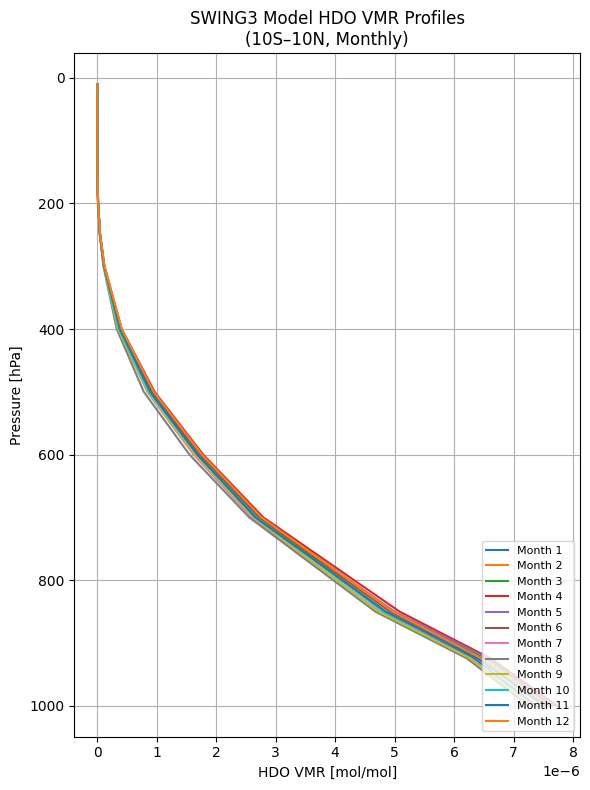

In [140]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# === Load SWING3 ===
ds = xr.open_dataset("SWING3_2006_subset.nc")
lon = ds['lon'].values
lat = ds['lat'].values
p = ds['p'].values
dD = ds['dD'].values.astype(float)
q = ds['q'].values.astype(float)

# === Mask fill values ===
dD[dD == -999] = np.nan
q[q == -999] = np.nan

# === Constants ===
Rvsmow = 3.1152e-4
M_air = 28.9647
M_H2O = 18.01528

# === Subset latitude range [-10, 10] and plot all months
lat_mask = (lat >= -10) & (lat <= 10)

plt.figure(figsize=(6, 8))

for m in range(dD.shape[0]):  # assuming shape is (month, level, lat, lon)
    dD_eq = dD[m, :, lat_mask, :]
    q_eq  = q[m, :, lat_mask, :]

    dD_mean = np.nanmean(np.nanmean(dD_eq, axis=2), axis=0)
    q_mean  = np.nanmean(np.nanmean(q_eq, axis=2), axis=0)

    q_vmr = (q_mean / M_H2O) / ((q_mean / M_H2O) + ((1 - q_mean) / M_air))
    HDO_vmr1 = q_vmr * Rvsmow * (1 + dD_mean / 1000)

    plt.plot(HDO_vmr1, p, label=f'Month {m+1}')

plt.gca().invert_yaxis()
plt.xlabel('HDO VMR [mol/mol]')
plt.ylabel('Pressure [hPa]')
plt.title('SWING3 Model HDO VMR Profiles\n(10S–10N, Monthly)')
plt.legend(loc='lower right', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


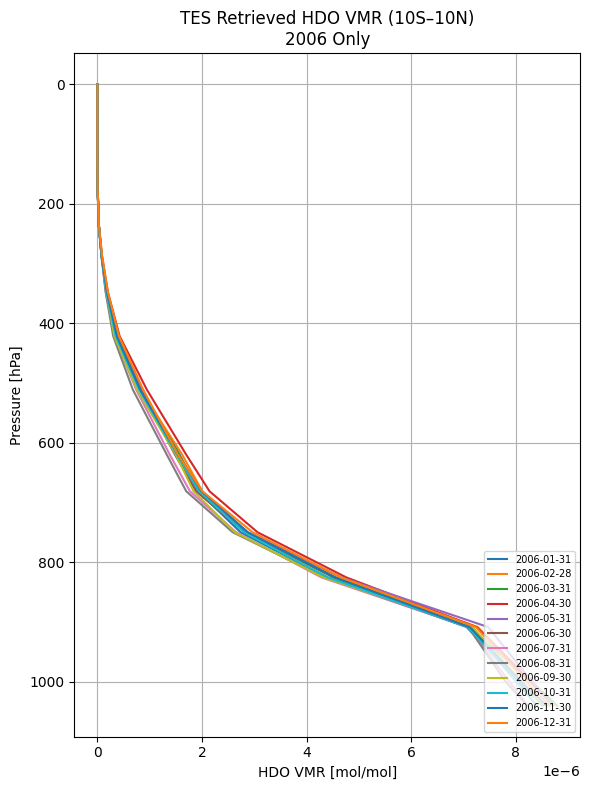

In [143]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# === Load TES ===
sat = xr.open_dataset("TES_monthly_5deg_strict.nc")
tes_lat = sat['lat'].values
tes_lon = sat['lon'].values
tes_p   = sat['level'].values
tes_time = sat['time'].values

# === Identify indices for 2006 only
if np.issubdtype(tes_time.dtype, np.datetime64):
    time_mask = (tes_time >= np.datetime64('2006-01-01')) & (tes_time <= np.datetime64('2006-12-31'))
else:
    base_date = datetime(2000, 1, 1)
    date_list = [base_date + np.timedelta64(int(t), 'D') for t in tes_time]
    time_mask = [(d.year == 2006) for d in date_list]

valid_indices = np.where(time_mask)[0]

# === Spatial mask
lat_mask = (tes_lat >= -10) & (tes_lat <= 10)

plt.figure(figsize=(6, 8))

for t_tes in valid_indices:
    user_date_str = str(np.datetime_as_string(tes_time[t_tes], unit='D')) if np.issubdtype(tes_time.dtype, np.datetime64) else f"time index {t_tes}"

    HDO_ret = sat['HDO_vmr'].values[t_tes, :, lat_mask, :]
    HDO_ret[HDO_ret == -999] = np.nan
    HDO_ret_avg = np.nanmean(np.nanmean(HDO_ret, axis=2), axis=0)

    plt.plot(HDO_ret_avg, tes_p, label=user_date_str)

plt.gca().invert_yaxis()
plt.xlabel('HDO VMR [mol/mol]')
plt.ylabel('Pressure [hPa]')
plt.title('TES Retrieved HDO VMR (10S–10N)\n2006 Only')
plt.legend(fontsize=7, loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
